<font size=6><b>lec08. [실전-데이콘] 전화해지 고객 분류_김원겸

<img src="./imgs/lec08.png">
* ref : * ref : https://dacon.io/competitions/official/236075/data

In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [26]:
# ----------------- 학습 ----------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import (XGBClassifier, plot_importance)
from lightgbm import LGBMClassifier


# ----------------- 평가 ----------------------
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from scikitplot.metrics import plot_roc_curve, plot_precision_recall_curve 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import Binarizer


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Data Load

In [27]:
train = pd.read_csv("./datasets/train.csv")
test  = pd.read_csv("./datasets/test.csv")
submit = pd.read_csv("./datasets/sample_submission.csv")

train = train.drop(["ID"], axis = 1)
test = test.drop(["ID"], axis = 1)

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30200 entries, 0 to 30199
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   가입일      30200 non-null  int64  
 1   음성사서함이용  30200 non-null  int64  
 2   주간통화시간   30200 non-null  float64
 3   주간통화횟수   30200 non-null  int64  
 4   주간통화요금   30200 non-null  float64
 5   저녁통화시간   30200 non-null  float64
 6   저녁통화횟수   30200 non-null  int64  
 7   저녁통화요금   30200 non-null  float64
 8   밤통화시간    30200 non-null  float64
 9   밤통화횟수    30200 non-null  int64  
 10  밤통화요금    30200 non-null  float64
 11  상담전화건수   30200 non-null  int64  
 12  전화해지여부   30200 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 3.0 MB


# EDA

In [29]:
train.head()

,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
0,329,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0
1,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0
2,93,28,282.4,323,34.2,207.0,322,32.82,280.8,328,8.28,0,0
3,223,1,221.4,223,25.1,233.0,61,23.90,203.8,234,9.36,0,0
4,222,0,96.3,222,28.7,223.9,69,28.08,263.1,223,2.80,8,0


양성비율 : 10.986755
0    26882
1     3318
Name: 전화해지여부, dtype: int64


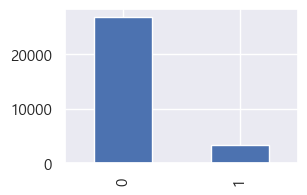

In [30]:
print( f"양성비율 : {len(train[train['전화해지여부']== 1]) / len(train) * 100 :2f}" )
print( train['전화해지여부'].value_counts() )
train['전화해지여부'].value_counts().plot(kind='bar', figsize=(3,2))
plt.show()

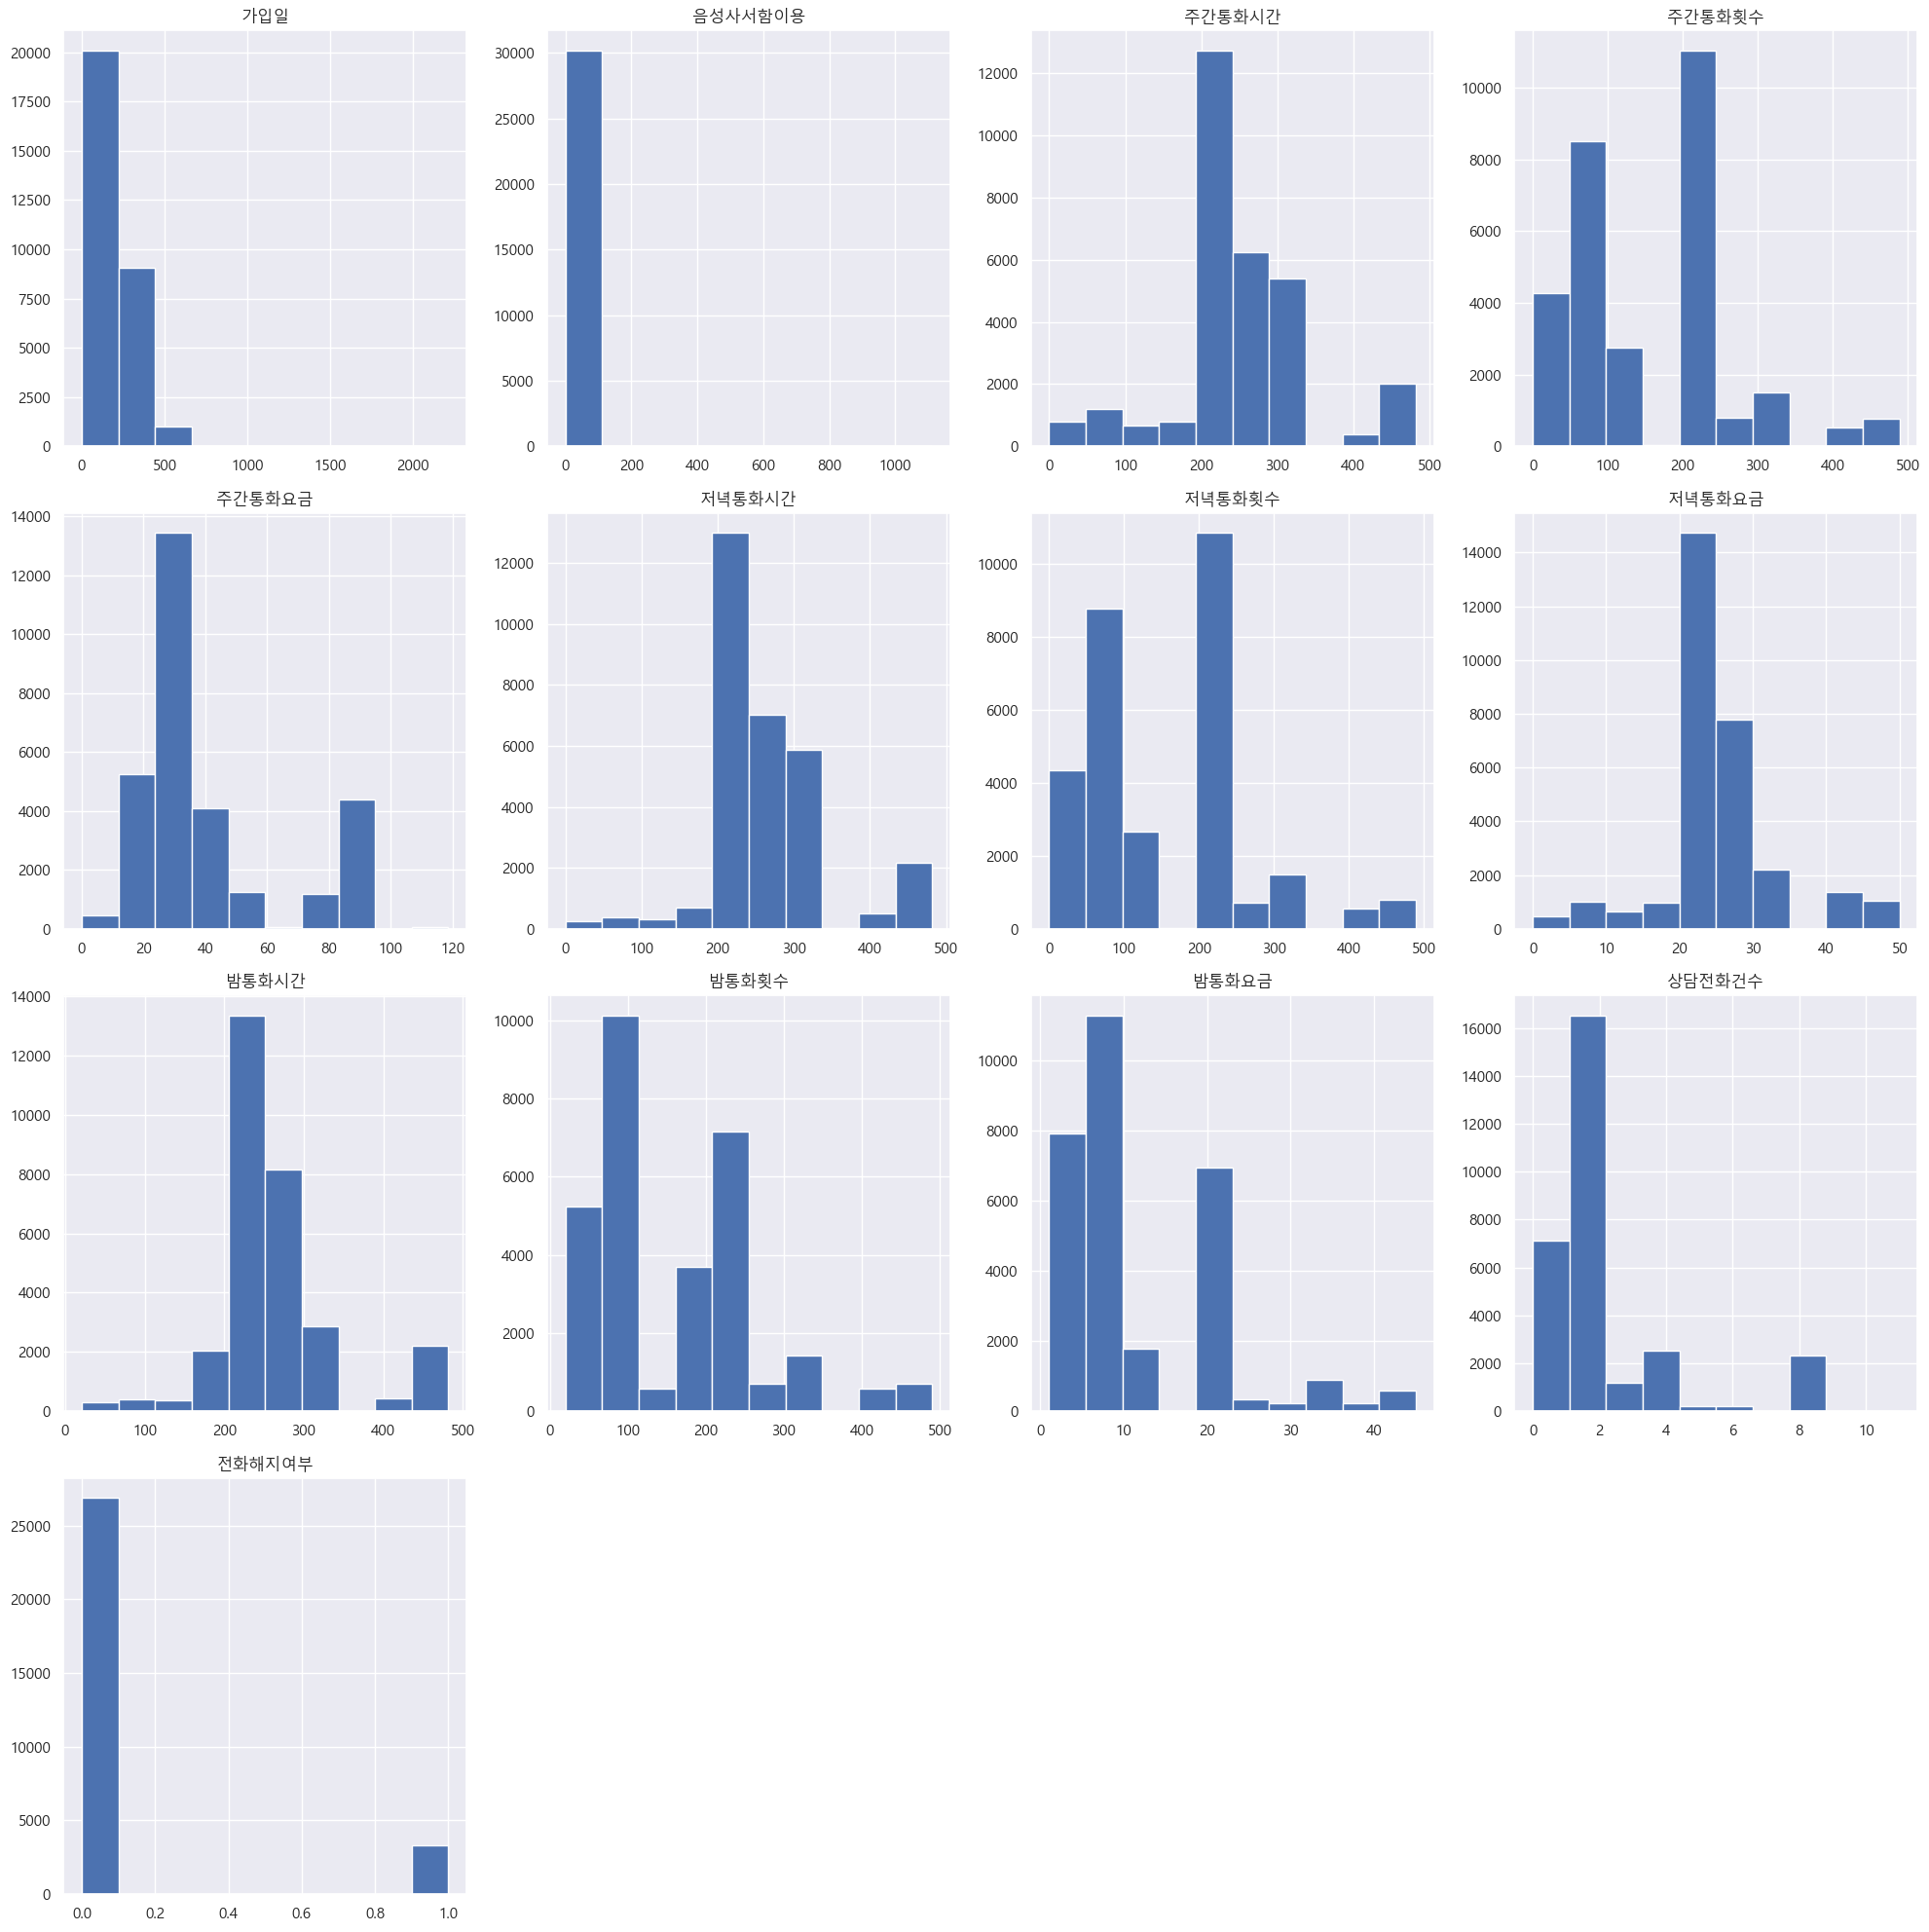

In [31]:
train.hist(figsize=(20,20))
plt.tight_layout()
plt.show()

In [32]:
pd.concat([train[train['전화해지여부']==1].describe().T, train[train['전화해지여부']==0].describe().T], axis=1)

,count,mean,std,min,25%,50%,75%,max,count,mean,std,min,25%,50%,75%,max
가입일,3318.0,162.088608,120.112890,1.00,67.00,135.00,229.000,2012.00,26882.0,159.441857,124.193729,1.00,63.00,116.00,228.00,2212.00
음성사서함이용,3318.0,7.587101,18.348552,0.00,0.00,1.00,1.000,117.00,26882.0,12.587159,25.566918,0.00,0.00,1.00,23.00,1112.00
주간통화시간,3318.0,257.764708,80.513591,0.10,224.20,250.25,290.800,481.90,26882.0,249.674619,84.830161,0.00,222.50,233.60,289.40,481.20
주간통화횟수,3318.0,162.348403,100.104352,0.00,88.00,143.00,223.000,489.00,26882.0,158.784131,101.747847,0.00,88.00,115.00,223.00,489.00
주간통화요금,3318.0,36.406841,19.427776,0.10,24.00,29.80,40.575,117.80,26882.0,41.669660,23.536478,0.00,24.50,31.20,46.20,118.60
저녁통화시간,3318.0,263.212899,68.344831,21.10,223.90,244.10,289.900,481.40,26882.0,263.251451,74.741785,0.10,223.70,242.95,290.40,481.60
저녁통화횟수,3318.0,157.230561,100.908386,20.00,87.00,111.00,223.000,489.00,26882.0,158.628078,102.359429,0.00,87.00,112.00,223.00,489.00
저녁통화요금,3318.0,25.433927,7.490529,2.29,22.22,23.32,28.880,49.89,26882.0,25.389364,8.223539,0.00,22.22,23.30,28.82,49.98
밤통화시간,3318.0,262.835142,67.395499,22.60,223.70,244.30,290.100,481.00,26882.0,263.512730,74.529181,20.80,223.70,242.70,290.50,481.80
밤통화횟수,3318.0,156.143761,101.216735,20.00,83.00,110.00,223.000,488.00,26882.0,157.158954,101.785060,20.00,87.00,107.00,222.00,490.00


In [33]:
# Pairplot

<img src = "./image1.png">

In [34]:
train[train['전화해지여부']==0].describe().T

,count,mean,std,min,25%,50%,75%,max
가입일,26882.0,159.441857,124.193729,1.00,63.00,116.00,228.00,2212.00
음성사서함이용,26882.0,12.587159,25.566918,0.00,0.00,1.00,23.00,1112.00
주간통화시간,26882.0,249.674619,84.830161,0.00,222.50,233.60,289.40,481.20
주간통화횟수,26882.0,158.784131,101.747847,0.00,88.00,115.00,223.00,489.00
주간통화요금,26882.0,41.669660,23.536478,0.00,24.50,31.20,46.20,118.60
저녁통화시간,26882.0,263.251451,74.741785,0.10,223.70,242.95,290.40,481.60
저녁통화횟수,26882.0,158.628078,102.359429,0.00,87.00,112.00,223.00,489.00
저녁통화요금,26882.0,25.389364,8.223539,0.00,22.22,23.30,28.82,49.98
밤통화시간,26882.0,263.512730,74.529181,20.80,223.70,242.70,290.50,481.80
밤통화횟수,26882.0,157.158954,101.785060,20.00,87.00,107.00,222.00,490.00


In [35]:
for col in train.columns:
    print(col, train[col].nunique())

가입일 345
음성사서함이용 76
주간통화시간 2771
주간통화횟수 239
주간통화요금 735
저녁통화시간 2606
저녁통화횟수 241
저녁통화요금 1840
밤통화시간 2545
밤통화횟수 233
밤통화요금 1216
상담전화건수 11
전화해지여부 2


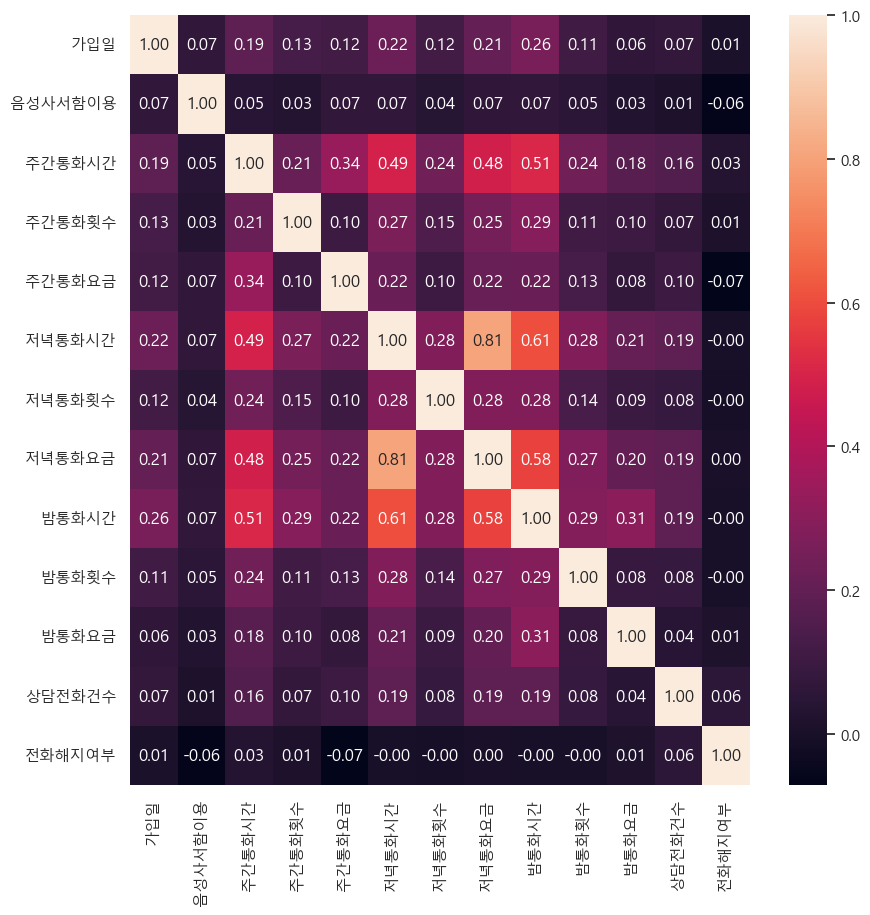

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), fmt=".2f", annot=True)
plt.show()

## PCA

In [37]:
# temp = train.drop(['전화해지여부'], axis=1)
# scaler = StandardScaler()
# temp = scaler.fit_transform(temp)
# pca = PCA()
# temp_pca = pca.fit_transform(temp)
# # temp['target'] = train['전화해지여부']

# for i in enumerate(temp):
#     plt.scatter(temp_pca[-1:,], temp_pca[:,i] )
#     plt.xlabel('PC1')
#     plt.ylabel('PC2')
#     plt.show()

In [38]:
# temp = pd.DataFrame(temp)
# temp

## 학습 & 평가

In [39]:
a = train[train['전화해지여부']==0].describe().T
b = train[train['전화해지여부']==1].describe().T

df = pd.concat([a,b],axis=1)
df.head()

,count,mean,std,min,25%,50%,75%,max,count,mean,std,min,25%,50%,75%,max
가입일,26882.0,159.441857,124.193729,1.0,63.0,116.0,228.0,2212.0,3318.0,162.088608,120.112890,1.0,67.0,135.00,229.000,2012.0
음성사서함이용,26882.0,12.587159,25.566918,0.0,0.0,1.0,23.0,1112.0,3318.0,7.587101,18.348552,0.0,0.0,1.00,1.000,117.0
주간통화시간,26882.0,249.674619,84.830161,0.0,222.5,233.6,289.4,481.2,3318.0,257.764708,80.513591,0.1,224.2,250.25,290.800,481.9
주간통화횟수,26882.0,158.784131,101.747847,0.0,88.0,115.0,223.0,489.0,3318.0,162.348403,100.104352,0.0,88.0,143.00,223.000,489.0
주간통화요금,26882.0,41.669660,23.536478,0.0,24.5,31.2,46.2,118.6,3318.0,36.406841,19.427776,0.1,24.0,29.80,40.575,117.8


In [40]:
y_s=train['전화해지여부']
X_s=train.drop(['가입일', '주간통화시간', '주간통화횟수', '주간통화요금', '밤통화횟수', '상담전화건수','전화해지여부'],axis=1)
from imblearn.over_sampling import SMOTE
X_o, y_o = SMOTE(sampling_strategy='auto', random_state=2021).fit_resample(X_s,y_s)
print(  len(X_s), len(y_s) )

y_s.value_counts()

30200 30200


0    26882
1     3318
Name: 전화해지여부, dtype: int64

In [41]:
# y_s = train['전화해지여부']
# X_s = train.drop(['가입일', '주간통화횟수', '밤통화횟수', '상담전화건수','전화해지여부'], axis=1)
# from imblearn.over_sampling import SMOTE
# X_o, y_o = SMOTE(sampling_strategy='auto', random_state=2021).fit_resample(X_s,y_s)
# # print(  len(X_s), len(y_s) )

# y_s.value_counts()
# # [DecisionTreeClassifier / RandomForestClassifier / XGBClassifier / LGBMClassifier / VotingClassifier]
# model = XGBClassifier(random_state=0)
# Xo_tr, Xo_ts,yo_tr,yo_ts = train_test_split(X_o,y_o,test_size=0.2,random_state=0)
# model.fit(Xo_tr, yo_tr)
# yo_pred = model.predict(Xo_ts)
# # proba = model.predict_proba(Xo_ts)
# score_over = accuracy_score(yo_ts, yo_pred)

# f1_over = f1_score(yo_ts, yo_pred, average='binary')

# # print( roc_auc_score(yo_ts, proba, multi_class="ovr", average="macro") )
# print(confusion_matrix(yo_ts, yo_pred) )
# print(f"f1 : {f1_over:.5}")

In [42]:
# y_s = train['전화해지여부']
# X_s = train.drop(['가입일', '주간통화횟수', '밤통화횟수', '상담전화건수','전화해지여부'], axis=1)
# from imblearn.over_sampling import SMOTE
# X_o, y_o = SMOTE(sampling_strategy='auto', random_state=2021).fit_resample(X_s,y_s)
# # print(  len(X_s), len(y_s) )

# y_s.value_counts()
# # [DecisionTreeClassifier / RandomForestClassifier / XGBClassifier / LGBMClassifier / VotingClassifier]
# model = LGBMClassifier(random_state=0)
# Xo_tr, Xo_ts,yo_tr,yo_ts = train_test_split(X_o,y_o,test_size=0.2,random_state=0)
# model.fit(Xo_tr, yo_tr)
# yo_pred = model.predict(Xo_ts)
# # proba = model.predict_proba(Xo_ts)
# score_over = accuracy_score(yo_ts, yo_pred)

# f1_over        = f1_score(yo_ts, yo_pred, average='binary')

# # print( roc_auc_score(yo_ts, proba, multi_class="ovr", average="macro") )
# print(confusion_matrix(yo_ts, yo_pred) )
print(f"f1 : {f1_over:.5}")

f1 : 0.87444


In [43]:
# y_s = train['전화해지여부']
# X_s = train.drop(['가입일', '주간통화횟수', '밤통화횟수', '상담전화건수','전화해지여부'], axis=1)
# from imblearn.over_sampling import SMOTE
# X_o, y_o = SMOTE(sampling_strategy='auto', random_state=2021).fit_resample(X_s,y_s)
# # print(  len(X_s), len(y_s) )

# y_s.value_counts()
# # [DecisionTreeClassifier / RandomForestClassifier / XGBClassifier / LGBMClassifier / VotingClassifier]
# model = LGBMClassifier(random_state=0)
# Xo_tr, Xo_ts,yo_tr,yo_ts = train_test_split(X_o,y_o,test_size=0.2,random_state=0)
# model.fit(Xo_tr, yo_tr)
# yo_pred = model.predict(Xo_ts)
# # proba = model.predict_proba(Xo_ts)
# score_over = accuracy_score(yo_ts, yo_pred)

# f1_over        = f1_score(yo_ts, yo_pred, average='binary')


# print(confusion_matrix(yo_ts, yo_pred) )
# # print( roc_auc_score(yo_ts, proba, multi_class="ovr", average="macro") )
# print(f"f1 : {f1_over:.5}")

In [44]:
# y_s = train['전화해지여부']
# X_s = train.drop(['가입일', '주간통화횟수', '밤통화횟수', '상담전화건수','전화해지여부'], axis=1)
# from imblearn.over_sampling import SMOTE
# X_o, y_o = SMOTE(sampling_strategy='auto', random_state=2021).fit_resample(X_s,y_s)
# # print(  len(X_s), len(y_s) )

# y_s.value_counts()
# # [DecisionTreeClassifier / RandomForestClassifier / XGBClassifier / LGBMClassifier / VotingClassifier]




# model = VotingClassifier([("XGB", XGBClassifier(random_state=0)), ("RF", RandomForestClassifier(random_state=0))])
# Xo_tr, Xo_ts,yo_tr,yo_ts = train_test_split(X_o,y_o,test_size=0.2,random_state=0)
# model.fit(Xo_tr, yo_tr)
# yo_pred = model.predict(Xo_ts)
# # proba = model.predict_proba(Xo_ts)
# score_over = accuracy_score(yo_ts, yo_pred)

# f1_over        = f1_score(yo_ts, yo_pred, average='binary')

# # print( roc_auc_score(yo_ts, proba, multi_class="ovr", average="macro") )
# print(confusion_matrix(yo_ts, yo_pred) )
# print(f"f1 : {f1_over:.5}")

In [45]:
model = DecisionTreeClassifier(random_state=0)
Xo_tr, Xo_ts,yo_tr,yo_ts = train_test_split(X_o,y_o,test_size=0.2,random_state=0)
model.fit(Xo_tr, yo_tr)
yo_pred = model.predict(Xo_ts)
# proba = model.predict_proba(Xo_ts)
brz = Binarizer(threshold=0.25)
th_pred = brz.fit_transform(Xo_ts).reshape(-1, 1)
score_over = accuracy_score(yo_ts, yo_pred)
f1_over        = f1_score(yo_ts, yo_pred, average='binary')
precision_over = precision_score(yo_ts, yo_pred, average='binary')
recall_over    = recall_score(yo_ts, yo_pred, average='binary')

# print( roc_auc_score(yo_ts, proba, multi_class="ovr", average="macro") )
print(confusion_matrix(yo_ts, yo_pred) )
print(f"accuracy : {score_over:.5f} / f1 : {f1_over:.5} / precision : {precision_over:.5} / recall : {recall_over:.5}")

[[4531  838]
 [ 710 4674]]
accuracy : 0.85604 / f1 : 0.85793 / precision : 0.84797 / recall : 0.86813


In [49]:
test = test.drop([ '가입일', '주간통화횟수', '주간통화시간','주간통화요금', '밤통화횟수', '상담전화건수'],axis=1)

KeyError: "['가입일', '주간통화횟수', '밤통화횟수', '상담전화건수'] not found in axis"

In [ ]:
train.shape, test.shape

In [ ]:
submit_arr = model.predict(test)
submit_csv = pd.read_csv('./datasets/sample_submission.csv')
submit_csv['전화해지여부'] = submit_arr
submit_csv.to_csv('./submit77.csv', index=False)